In [72]:
import sys
sys.path.append("../../script")

import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

from data_preparation import *
from utils import GridScore

# Import et Préparation des données

In [2]:
train = pd.read_csv("../../data/application_train_vf.csv")

In [177]:
train["NAME_CONTRACT_TYPE"].str.replace(' ', '_')

0         Cash_loans
1         Cash_loans
2         Cash_loans
3         Cash_loans
4         Cash_loans
             ...    
306102    Cash_loans
306103    Cash_loans
306104    Cash_loans
306105    Cash_loans
306106    Cash_loans
Name: NAME_CONTRACT_TYPE, Length: 306107, dtype: object

In [3]:
dataprep = DataPreparation(train, 0.3)
train_prepared = dataprep.get_prepared_data()

Variables extérieures récupérées ✅
Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 10/10 [02:55<00:00, 17.60s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [179]:
train_prepared["NAME_CONTRACT_TYPE"] = train_prepared["NAME_CONTRACT_TYPE"].str.replace(" ", "_")

In [180]:
df_train = train_prepared.iloc[:280000, :]
df_test = train_prepared.iloc[280000:, :]

In [181]:
features = ['REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_ENDDATE_disc_int', 'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE','TARGET']

In [182]:
df_train[features]

,REGION_RATING_CLIENT_W_CITY,DAYS_CREDIT_ENDDATE_disc_int,RATE_DOWN_PAYMENT_disc_int,AMT_PAYMENT_disc_int,NAME_INCOME_TYPE_discret,OCCUPATION_TYPE_discret,NAME_CONTRACT_TYPE,TARGET
0,trois,[-243.0;214193.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,0
1,trois,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,0
2,un_deux,[-243.0;214193.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash_loans,0
3,un_deux,[-155271.0;-244.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash_loans,0
4,un_deux,[-243.0;214193.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash_loans,0
...,...,...,...,...,...,...,...,...
279995,un_deux,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,1
279996,un_deux,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,1
279997,un_deux,[-155271.0;-244.0],[0.21;4.48],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,1
279998,un_deux,[-243.0;214193.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash_loans,1


In [183]:
dic_ref = {
    'REGION_RATING_CLIENT_W_CITY' : "un_deux",
    'DAYS_CREDIT_ENDDATE_disc_int' : "[-155271.0;-244.0]",
    'RATE_DOWN_PAYMENT_disc_int' : "[0.21;4.48]",
    'AMT_PAYMENT_disc_int' : "[128559.46;25537053.78]",
    'NAME_INCOME_TYPE_discret' : "Low_income",
    'OCCUPATION_TYPE_discret' : "high_skilled",
    'NAME_CONTRACT_TYPE' : "Revolving_loans"
}

In [184]:
new_var = []
for var in dic_ref.keys(): 
    new_var.append(f'{var}_{dic_ref[var]}')
    df_train[f'{var}_{dic_ref[var]}'] = df_train[var].apply(lambda x : 0 if x == dic_ref[var] else 1)

In [185]:
new_var

['REGION_RATING_CLIENT_W_CITY_un_deux',
 'DAYS_CREDIT_ENDDATE_disc_int_[-155271.0;-244.0]',
 'RATE_DOWN_PAYMENT_disc_int_[0.21;4.48]',
 'AMT_PAYMENT_disc_int_[128559.46;25537053.78]',
 'NAME_INCOME_TYPE_discret_Low_income',
 'OCCUPATION_TYPE_discret_high_skilled',
 'NAME_CONTRACT_TYPE_Revolving_loans']

In [186]:
dic_ref

{'REGION_RATING_CLIENT_W_CITY': 'un_deux',
 'DAYS_CREDIT_ENDDATE_disc_int': '[-155271.0;-244.0]',
 'RATE_DOWN_PAYMENT_disc_int': '[0.21;4.48]',
 'AMT_PAYMENT_disc_int': '[128559.46;25537053.78]',
 'NAME_INCOME_TYPE_discret': 'Low_income',
 'OCCUPATION_TYPE_discret': 'high_skilled',
 'NAME_CONTRACT_TYPE': 'Revolving_loans'}

In [187]:
dic_not_ref = {}
for var in dic_ref.keys():
    modality = df_train[df_train[var] != dic_ref[var]][var].mode()[0]
    dic_not_ref[var] = modality

print(dic_not_ref)

{'REGION_RATING_CLIENT_W_CITY': 'trois', 'DAYS_CREDIT_ENDDATE_disc_int': '[-243.0;214193.0]', 'RATE_DOWN_PAYMENT_disc_int': '[-0.0;0.21]', 'AMT_PAYMENT_disc_int': '[0.0;128559.02]', 'NAME_INCOME_TYPE_discret': 'high_income', 'OCCUPATION_TYPE_discret': 'low_skilled', 'NAME_CONTRACT_TYPE': 'Cash_loans'}


In [295]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import re

class XGB_model():
    def __init__(self, train, dic_ref):
        self.train = train
        self.dic_ref = dic_ref
    
    def get_dic_notref(self):
        self.dic_not_ref = {}
        for var in self.dic_ref.keys():
            modality = self.train[self.train[var] != self.dic_ref[var]][var].mode()[0]
            self.dic_not_ref[var] = modality
    
    def prepare_data(self):
        self.new_var = {}
        translation_table = str.maketrans({'[': 'zz',
                                           ']': 'vv',
                                           ';': 'ww',
                                           '-': 'ff',
                                           '.': 'pp'})
        
        for var in self.dic_ref.keys(): 
            self.new_var[f'{var}_{self.dic_ref[var]}'] = f'{var}_{self.dic_ref[var]}'.translate(translation_table)
            self.train.loc[:, f'{var}_{self.dic_ref[var]}'] = self.train[var].apply(lambda x: 0 if x == self.dic_ref[var] else 1)
            self.train = self.train.rename(columns = {f'{var}_{self.dic_ref[var]}' : self.new_var[f'{var}_{self.dic_ref[var]}']})
        
    def split_data(self):
        X = self.train[self.new_var.values()]
        y = self.train["TARGET"]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

    def train_model(self):
        params = {'max_depth': 10, 'eta': 0.06739876573943267, 'gamma': 1.0887983081146109e-05, 'colsample_bytree': 0.5551288232191764, 'subsample': 0.9618418605416359, 'n_estimators': 97, 'alpha': 0.48989283547214435}
        self.model = xgb.XGBClassifier(**params)
        self.model.fit(self.X_train, self.y_train)
    
    def compute_metrics(self):
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_prob)
        self.roc_auc = auc(fpr, tpr)
        self.gini = 2*self.roc_auc-1
        
    def compute_shap_values(self):
        explainer = shap.TreeExplainer(self.model)

        self.shap_values = explainer.shap_values(self.X_train)
        #shap.summary_plot(self.shap_values, self.X_train)
        
        #shap_values_single = explainer.shap_values(self.X_train.iloc[[0]])
        #shap.force_plot(explainer.expected_value, shap_values_single, self.X_train.iloc[[0]])
    
    def extract_features_name(self, string):
        bracket_content = re.search(r'(\[[^\]]+\])', string)
        if bracket_content:
            return(string.split(bracket_content.group(1))[0][:-1])
        else:
            last_part = re.search(r'[^_]+_[^_]+$', string)
            if last_part:
                return(string.split(last_part.group(0))[0][:-1])
    
    def get_modality(self, row):
        var = row["Var_ref"]
        if '_ref' in var :
            return(dic_ref[var.split('_ref')[0]] + '_ref')
        else :
            return(dic_not_ref[var])

    
    def get_shap_coef(self):
        shaps = pd.DataFrame(self.shap_values,columns = self.X_train.columns)
        shaps['TARGET'] = self.y_train.values
        
        shapley_values = pd.DataFrame(columns=['Coef','Variable'])

        dic_temp = {value : key for key, value in self.new_var.items()}
        for col in self.X_train.columns:
            shapley_values.loc[len(shapley_values)] = [shaps[shaps[col] < 0][col].mean(),dic_temp[col]]
            shapley_values.loc[len(shapley_values)] = [shaps[shaps[col] > 0][col].mean(),dic_temp[col]]

        shapley_values["Var_ok"] = shapley_values["Variable"].apply(lambda x: self.extract_features_name(x))

        unique_var_ok_indexes = shapley_values.drop_duplicates('Var_ok', keep='first').index
        shapley_values["Var_ref"] = shapley_values["Var_ok"].copy()
        shapley_values.loc[unique_var_ok_indexes, 'Var_ref'] += '_ref'
        shapley_values["Modality"] = shapley_values.apply(lambda x: self.get_modality(x), axis=1)
        shapley_values["Var_ref"] = shapley_values["Var_ref"].apply(lambda x : x.split("_ref")[0])
        
        shapley_values = shapley_values[["Coef", "Var_ref", "Modality"]]
        shapley_values = shapley_values.rename(columns = {"Coef" : "Coefficient", 
                                                          "Var_ref" : "Variable"})

        return(shapley_values)
    
    def run_xgb_model(self):
        self.get_dic_notref()
        self.prepare_data()
        self.split_data()
        self.train_model()
        self.compute_metrics()
        self.compute_shap_values()
        return(self.get_shap_coef())

In [296]:
test = XGB_model(train_prepared[features], dic_ref)

In [297]:
sh = test.run_xgb_model()

In [298]:
import re
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore', category=FutureWarning,
                        message="Series.__getitem__ treating keys as positions is deprecated")


class GridScoreXGB():
    def __init__(self, df, shap_df):
        self.df = df
        self.shap_df = shap_df
        self.variable_pattern = r'C\(\s*([^,]+?)(?=,|\))'
        self.reference_pattern = r'Treatment\(reference="([^"]+)"\)'

    def calculate_percentage_default(self, row, data_frame):
        variable = row['Variable']

        if variable == "Intercept":
            return (0)

        modality = row['Modality']
        if modality.isdigit():
            modality = int(modality)

        if '_ref' in modality:
            modality = modality.split('_ref')[0]

        default_count = data_frame[data_frame[variable] == modality]["TARGET"].sum()
        total_count = data_frame.shape[0]
        return round((default_count / total_count) * 100, 2)

    def calculate_pcentage_class(self, row, data_frame):
        variable = row['Variable']
        if variable == "Intercept":
            return (0)

        modality = row['Modality']
        if modality.isdigit():
            modality = int(modality)

        if '_ref' in modality:
            modality = modality.split('_ref')[0]

        default_count = data_frame[data_frame[variable] == modality].shape[0]
        total_count = data_frame.shape[0]
        return round((default_count / total_count) * 100, 2)

    def calculate_contribution(self, score_card):
        mean_scores = score_card.groupby('Variable')['Score'].mean().to_dict()
        score_card['Contribution'] = score_card.apply(
            lambda x: (x["Pcentage_Classe"] / 100) * (x["Score"] - mean_scores.get(x["Variable"], 0)) ** 2,
            axis=1)
        contributions = np.sqrt(score_card.groupby('Variable')['Contribution'].sum()).to_dict()

        contrib_totale = sum(contributions.values())
        pcentage_contrib = {key: value / contrib_totale for key, value in contributions.items()}
        score_card['Contribution'] = score_card.apply(lambda x: round(pcentage_contrib[x["Variable"]], 2) * 100, axis=1)

        return (score_card)

    def compute_score(self, row):
        num = np.abs(self.max[row["Variable"]] - row["Coefficient"])
        denominateur = sum(self.max[key] - self.min[key] for key in self.min)
        return ((num / denominateur) * 1000)

    def extract_modality(self, reference_string):
        modality_pattern = r'\[T\.([^\]]+\]?)'
        match = re.search(modality_pattern, reference_string)

        if match:
            modality = match.group(1)
            if modality[-1] == "]" and not re.search(r'\d+\]$', modality):
                return modality[:-1]
            return modality
        else:
            return 'N/A'

    def compute_grid_score(self):
        score_card = self.shap_df.copy()
        
        self.max = score_card.groupby("Variable")["Coefficient"].max().to_dict()
        self.min = score_card.groupby("Variable")["Coefficient"].min().to_dict()

        score_card["Score"] = 0
        score_card["Score"] = score_card.apply(lambda x: self.compute_score(x), axis=1)

        score_card["Pcentage_Défaut"] = score_card.apply(lambda row: self.calculate_percentage_default(row, self.df),
                                                         axis=1)
        score_card["Pcentage_Classe"] = score_card.apply(lambda row: self.calculate_pcentage_class(row, self.df),
                                                         axis=1)

        score_card = self.calculate_contribution(score_card)

        self.score_card = score_card[['Variable', "Modality", 'Coefficient', "Score",
                                 "Contribution", "Pcentage_Défaut", "Pcentage_Classe"]]

        return self.score_card

    def compute_individual_score(self, row, features):
        score = 0
        for var in features :
            modality = row[var]
            score += self.score_dict[var][modality]
        return (score)

    def get_individual_score(self):
        self.score_dict = {}
        for index, row in self.score_card.iterrows():
            var = row["Variable"]
            mod = row["Modality"].split("_ref")[0]
            score = row["Score"]

            if var not in self.score_dict:
                self.score_dict[var] = {}
            self.score_dict[var][mod] = score

        features = list(self.score_dict.keys())

        df_score = self.df.copy()
        df_score["Score_ind"] = 0
        df_score["Score_ind"] = df_score.apply(lambda row: self.compute_individual_score(row, features), axis=1)
        return (df_score)


In [299]:
gs = GridScoreXGB(train_prepared, sh)

In [300]:
grid_score = gs.compute_grid_score()

In [303]:
grid_score

,Variable,Modality,Coefficient,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,REGION_RATING_CLIENT_W_CITY,un_deux_ref,-0.065662,153.627288,15.0,6.13,85.76
1,REGION_RATING_CLIENT_W_CITY,trois,0.338098,0.000000,15.0,1.55,14.24
2,DAYS_CREDIT_ENDDATE_disc_int,[-155271.0;-244.0]_ref,-0.270392,171.156802,17.0,2.57,44.56
3,DAYS_CREDIT_ENDDATE_disc_int,[-243.0;214193.0],0.179438,0.000000,17.0,5.10,55.44
4,RATE_DOWN_PAYMENT_disc_int,[0.21;4.48]_ref,-0.180778,96.099949,10.0,1.92,31.08
5,RATE_DOWN_PAYMENT_disc_int,[-0.0;0.21],0.071789,0.000000,10.0,5.75,68.92
6,AMT_PAYMENT_disc_int,[128559.46;25537053.78]_ref,-0.063947,79.483662,8.0,5.09,71.57
7,AMT_PAYMENT_disc_int,[0.0;128559.02],0.144950,0.000000,8.0,2.58,28.43
8,NAME_INCOME_TYPE_discret,Low_income_ref,-0.372623,180.304408,18.0,1.31,25.11
9,NAME_INCOME_TYPE_discret,high_income,0.101248,0.000000,18.0,6.36,74.89


In [305]:
grid_score["Contribution"].sum()

200.0

# Xgboost

In [9]:
df_train[['REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_ENDDATE_disc_int', 'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE','TARGET']]

,REGION_RATING_CLIENT_W_CITY,DAYS_CREDIT_ENDDATE_disc_int,RATE_DOWN_PAYMENT_disc_int,AMT_PAYMENT_disc_int,NAME_INCOME_TYPE_discret,OCCUPATION_TYPE_discret,NAME_CONTRACT_TYPE,TARGET
0,trois,[-243.0;214193.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash loans,0
1,trois,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash loans,0
2,un_deux,[-243.0;214193.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash loans,0
3,un_deux,[-155271.0;-244.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash loans,0
4,un_deux,[-243.0;214193.0],[-0.0;0.21],[0.0;128559.02],high_income,low_skilled,Cash loans,0
...,...,...,...,...,...,...,...,...
279995,un_deux,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash loans,1
279996,un_deux,[-155271.0;-244.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash loans,1
279997,un_deux,[-155271.0;-244.0],[0.21;4.48],[128559.46;25537053.78],high_income,low_skilled,Cash loans,1
279998,un_deux,[-243.0;214193.0],[-0.0;0.21],[128559.46;25537053.78],high_income,low_skilled,Cash loans,1


In [11]:
df_train['NAME_INCOME_TYPE_discret_high_income'] = df_train['NAME_INCOME_TYPE_discret'].apply(lambda x : 1 if x == 'high_income' else 0)
df_train['RATE_DOWN_PAYMENT_[0;0.2]'] = df_train['RATE_DOWN_PAYMENT_disc_int'].apply(lambda x : 1 if x == 0 else 0)
df_train['AMT_PAYMENT_[0;146933]'] = df_train['AMT_PAYMENT_disc_int'].apply(lambda x : 1 if x == 0 else 0)
df_train['NAME_CONTRACT_TYPE_Cash_loans'] = df_train['NAME_CONTRACT_TYPE'].apply(lambda x : 1 if x == 'Cash loans' else 0)
df_train['OCCUPATION_TYPE_discret_low_skilled'] = df_train['OCCUPATION_TYPE_discret'].apply(lambda x : 1 if x == 'low_skilled' else 0)

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_1607/1767289003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['NAME_INCOME_TYPE_discret_high_income'] = df_train['NAME_INCOME_TYPE_discret'].apply(lambda x : 1 if x == 'high_income' else 0)
/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_1607/1767289003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['RATE_DOWN_PAYMENT_[0;0.2]'] = df_train['RATE_DOWN_PAYMENT_disc_int'].apply(lambda x : 1 if x == 0 else 0)
/var/

In [13]:
df_train.drop(columns = ['OCCUPATION_TYPE_discret','NAME_CONTRACT_TYPE','AMT_PAYMENT_disc_int','RATE_DOWN_PAYMENT_disc_int','NAME_INCOME_TYPE_discret'],inplace = True)

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_1607/795465578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns = ['OCCUPATION_TYPE_discret','NAME_CONTRACT_TYPE','AMT_PAYMENT_disc_int','RATE_DOWN_PAYMENT_disc_int','NAME_INCOME_TYPE_discret'],inplace = True)


In [14]:
df_train.rename(columns = {'REGION_RATING_CLIENT_W_CITY_disc': 'REGION_RATING_CLIENT_W_CITY_[3;3]','DAYS_CREDIT_ENDDATE_disc' : 'DAYS_CREDIT_ENDDATE_[0;214193]'},inplace = True)

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_1607/3714237082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns = {'REGION_RATING_CLIENT_W_CITY_disc': 'REGION_RATING_CLIENT_W_CITY_[3;3]','DAYS_CREDIT_ENDDATE_disc' : 'DAYS_CREDIT_ENDDATE_[0;214193]'},inplace = True)


In [149]:
X = train_prepared2.drop(columns = ['TARGET'])
y = train_prepared2['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [150]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', 'zz').replace(']', 'vv').replace(';', 'ww').replace('-', 'ff').replace('.', 'pp')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', 'zz').replace(']', 'vv').replace(';', 'ww').replace('-', 'ff').replace('.', 'pp')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [151]:
X_test2.columns 

Index(['REGION_RATING_CLIENT_W_CITY_zz3ww3vv',
       'DAYS_CREDIT_ENDDATE_zz0ww214193vv',
       'NAME_INCOME_TYPE_discret_high_income', 'RATE_DOWN_PAYMENT_zz0ww0pp2vv',
       'AMT_PAYMENT_zz0ww146933vv', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OCCUPATION_TYPE_discret_low_skilled'],
      dtype='object')

In [152]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score

liste_var =X_train2.columns

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Utilisation de l'aire sous la courbe ROC comme métrique d'évaluation
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2[liste_var], y_train)
    y_pred_proba = model.predict_proba(X_test2[liste_var])[:, 1]  # Probabilité de la classe positive
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Calcul de l'aire sous la courbe ROC
    return auc_score

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-27 10:48:06,299] A new study created in memory with name: no-name-8428425e-47cc-47f0-8a23-c9392eaf9684
[I 2024-02-27 10:48:07,795] Trial 0 finished with value: 0.6233696835860393 and parameters: {'max_depth': 19, 'eta': 0.2948754837163624, 'gamma': 1.6638940623102458e-08, 'colsample_bytree': 0.615557306663375, 'subsample': 0.6322377617370255, 'n_estimators': 95, 'alpha': 0.15439516676842827}. Best is trial 0 with value: 0.6233696835860393.
[I 2024-02-27 10:48:09,782] Trial 1 finished with value: 0.624502351572051 and parameters: {'max_depth': 20, 'eta': 0.09039346279705804, 'gamma': 0.1022394923288858, 'colsample_bytree': 0.44427941301462115, 'subsample': 0.9449338377441103, 'n_estimators': 104, 'alpha': 0.6050820852748322}. Best is trial 1 with value: 0.624502351572051.
[I 2024-02-27 10:48:11,917] Trial 2 finished with value: 0.6228267640886457 and parameters: {'max_depth': 8, 'eta': 0.16580815967129212, 'gamma': 0.03138405464861721, 'colsample_bytree': 0.9291043169676325, 

Best parameters: {'max_depth': 10, 'eta': 0.06739876573943267, 'gamma': 1.0887983081146109e-05, 'colsample_bytree': 0.5551288232191764, 'subsample': 0.9618418605416359, 'n_estimators': 97, 'alpha': 0.48989283547214435}
Best positive f1 score: 0.6248177551670132


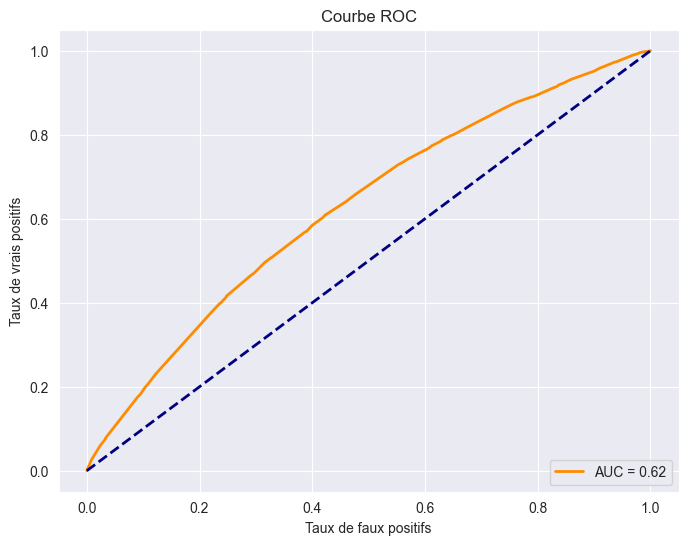

In [153]:
params = study.best_params

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train2[liste_var], y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test2[liste_var])[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

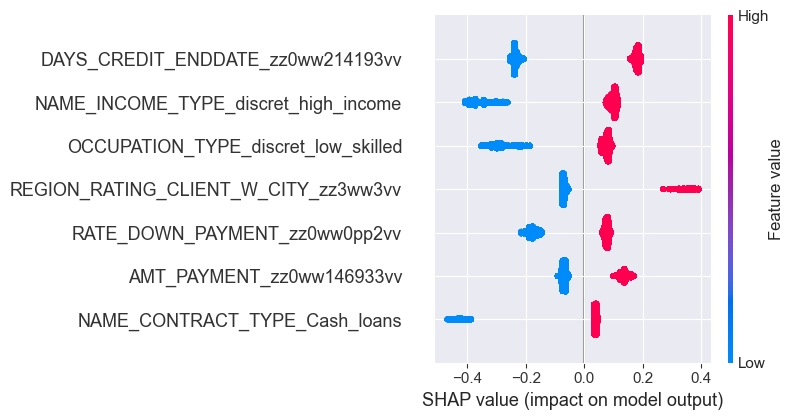

In [154]:
import shap
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train2[liste_var])

shap.summary_plot(shap_values, X_train2[liste_var])

shap_values_single = explainer.shap_values(X_train2[liste_var].iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2[liste_var].iloc[[0]])

# Création de coefficients shapley values

In [59]:
shaps = pd.DataFrame(shap_values,columns = X_train2.columns)
shaps['TARGET'] = y_train.values

In [60]:
shaps

,REGION_RATING_CLIENT_W_CITY_disc,DAYS_CREDIT_ENDDATE_disc,RATE_DOWN_PAYMENT_disc,AMT_PAYMENT_disc,NAME_INCOME_TYPE_discret_other,OCCUPATION_TYPE_discret_low_skilled,NAME_CONTRACT_TYPE_Revolving loans,TARGET
0,-0.066720,-0.251011,0.065394,-0.066431,-0.412013,0.051475,0.035209,0.0
1,-0.070565,0.182007,-0.182797,-0.066050,0.105519,0.082628,0.041166,0.0
2,-0.066834,-0.232114,0.077214,0.165621,0.112255,0.093326,-0.428789,0.0
3,0.366480,-0.263360,0.084811,-0.071767,0.125953,0.078753,0.042268,0.0
4,-0.066605,-0.231165,-0.169437,-0.059263,0.082586,-0.278735,0.042980,0.0
...,...,...,...,...,...,...,...,...
244880,-0.064549,0.177453,0.066857,-0.071835,-0.392974,0.062623,-0.431893,0.0
244881,-0.075476,0.186962,0.079868,-0.067628,0.113611,0.083602,0.041977,0.0
244882,-0.069298,0.171578,-0.179001,-0.056885,0.079778,-0.296408,0.045657,0.0
244883,-0.071964,-0.251005,0.078079,-0.070711,0.115987,0.077677,0.039159,0.0


In [61]:
shaps[shaps['REGION_RATING_CLIENT_W_CITY_disc']>0]['REGION_RATING_CLIENT_W_CITY_disc'].mean()

0.35830802

In [ ]:
shapley_values = pd.DataFrame()


In [62]:
X =shaps.drop(columns = ['TARGET'])
y = shaps['TARGET']
X = sm.add_constant(X)

shap_train, shap_test, y_train_shap, y_test_shap = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [63]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(y_train_shap, shap_train)

# Ajuster le modèle aux données
result = logit_model.fit()

# Afficher un résumé des résultats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.263239
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               195908
Model:                          Logit   Df Residuals:                   195900
Method:                           MLE   Df Model:                            7
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                 0.02746
Time:                        22:40:11   Log-Likelihood:                -51571.
converged:                       True   LL-Null:                       -53027.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -2.4979      0.009 

In [64]:
predicted_probabilities = result.predict(shap_test)

# Calculer l'AUC en utilisant les probabilités prédites et les vraies étiquettes de classe du jeu de test
auc = roc_auc_score(y_test_shap, predicted_probabilities)

print("AUC sur le jeu de test:", auc)

AUC sur le jeu de test: 0.6270340212349597
